# Week 6 - Logistic Regression

### Aims

By the end of this notebook you will be able to understand 

>* the binary logistic regression
>* the main performance metrics for classification
>* the improvement for the imbalanced data 
>* the basics of multi-class classification

1. [Setup](#setup)

2. [Binary Logistic Regression](#RBH)

3. [Model refinement](#refine)

4. [Regularization Example](#SKV)

5. [Imbalanced Data](#Imbal)

6. [Multi-class Example](#mclog)


This week we will be implementing the logistic regression for a classification problem. 

- We will start with the binary case and then look at some extensions of the logistic regression model
- For this purpose, the main data set is called `Default.csv` in the upcoming code snippets. You will have tasks tagged by (CORE) and (EXTRA) as usual. 
- For the multi-class example, we will turn back to the `iris data` example for the simplicity

---

# 1. General Setup <a id='setup'></a>

## 1.1. Packages

Now lets load in the packages you wil need for this workshop. Maybe there are some missing packages below or the ones with that is not necessary based on your

In [20]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

# Other necessary packages
from sklearn.datasets import load_iris           # for the Iris data
from IPython.display import Image                # displaying .png images
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.preprocessing import LabelEncoder   # binary encoding
from sklearn.pipeline import Pipeline            # combining classifier steps
from sklearn.preprocessing import PolynomialFeatures # make PolynomialFeatures
import warnings # prevent warnings
from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold #About randomized search over parameters
from scipy.stats.distributions import uniform, loguniform # About creating random C values for regularization

# from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
# from imblearn.metrics import classification_report_imbalanced
# import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

##  1.2 User Defined Helper Functions

Below are three helper functions we will be using in this workshop. You can create your own if you think it is necessary OR directly use already available helper functions within `sklearn library`.  

- `tidy_scores()`: Simple function for getting the summary of cross-validation results in a tidy way.
- `pretty_confusion_matrix()`: Returns the confusion matrix in a nicer way but works for only binary classification!
- `roc_plot()` : ROC curve plotting function based on a given threshold

You can modify the following functions based on your needs as well. These practices would be important while you are working on your project either. 

In [19]:
# tidy the output into a dataframe
# We will use for getting the summary of cross-validation results in some parts
def tidy_scores(score_dict):
    df = pd.DataFrame(score_dict)
    df.loc['mean'] = df.mean()
    df.loc['sd'] = df.std()
    df.rename({"test_score":"val_score"}, axis=1, inplace=True)
    df.index.name = "fold"
    return df.round(2)

In [21]:
# this creates the matplotlib graph to make the confmat look nicer
# WARNING 1: IT WORKS FOR ONLY BINARY CLASSIFICATION CASE !!!
# WARNING 2: The locations of TP, FP, TN, and FN are varying when you compared with our notes !!!

def pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]):

    labels_list = [["TN", "FP"], ["FN", "TP"]]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = str(confmat[i, j])+" ("+labels_list[i][j]+")"
            else:
                label = confmat[i, j]
            
            
            if [i,j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight = "bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
       
    # change the labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(['']+[labels[0], labels[1]])
        ax.set_yticklabels(['']+[labels[0], labels[1]])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.show()

In [22]:
# For ROC curve plotting function
def roc_plot(threshold = 0.5):
    i = (np.abs(roc.threshold - threshold)).idxmin()

    sns.lineplot(x='false positive rate', y='true positive rate', data=roc, ci=None)

    plt.plot([0,1],[0,1], 'k--', alpha=0.5) # 0-1 line 
    plt.plot(roc.iloc[i,0], roc.iloc[i,1], 'r.')

    plt.title("threshold = %.2f" % threshold)
    plt.show() 

## 1.3 Data

The dataset consists of **10000** individuals and whether their credit card has defaulted or not. 

Below is the column description: The main aim is to build the model using Logistic Regression and predict the person who is defaulted or not (classifying each individual). The included columns in the data set are as follows:

* `default` - Whether the individual has defaulted

* `student` - Whether the individual is the student

* `balance` - The balance in the individual's account

* `income` - Income of an individual

We read the data into python using pandas.





In [6]:
df_default = pd.read_csv("Default.csv", index_col=0)

# Lets just drop the student varible, 
# for simplicity we will focus on two main predictors; balance and income
df_default = df_default.drop("student", axis=1)
df_default.head()

,default,balance,income
1,No,729.526495,44361.62507
2,No,817.180407,12106.13470
3,No,1073.549164,31767.13895
4,No,529.250605,35704.49394
5,No,785.655883,38463.49588


We will start by doing explanatory data analysis (EDA) to examine the data set itself as usual, to get more insight about the data set. 

---

### 🚩 Exercise 1 (CORE)

Examine the structure of the data. Answer the following questions simply;

1. Do you observe anything from descriptive statistics that may influence our models?
2.  Are there any missing values in your data ? 
3. Look at how the varibles relate to each other (Response: Default, Predictors: Balance and Income) 

<details><summary><b><u>Hint</b></u></summary>
    
Maybe some scatterplot and boxplot for each feature in terms of different response class will be useful
    
</details>

In [7]:
#About data info 
print(df_default.info())

# Some descriptive statistics
# We invoke the .T to transpose the matrix for better viewing 
print(df_default.describe().T)

# Checking the missing values
print(df_default.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   balance  10000 non-null  float64
 2   income   10000 non-null  float64
dtypes: float64(2), object(1)
memory usage: 312.5+ KB
None
           count          mean           std         min           25%  \
balance  10000.0    835.374886    483.714985    0.000000    481.731105   
income   10000.0  33516.981876  13336.639563  771.967729  21340.462905   

                  50%           75%           max  
balance    823.636973   1166.308387   2654.322576  
income   34552.644800  43807.729275  73554.233500  
default    0
balance    0
income     0
dtype: int64


---

Firstly, the range of the features should be considered carefully since their scale is different. For that reason, classical StandardScaler can be used before using in the model construction. Apart from that, there is no missing value to deal with.


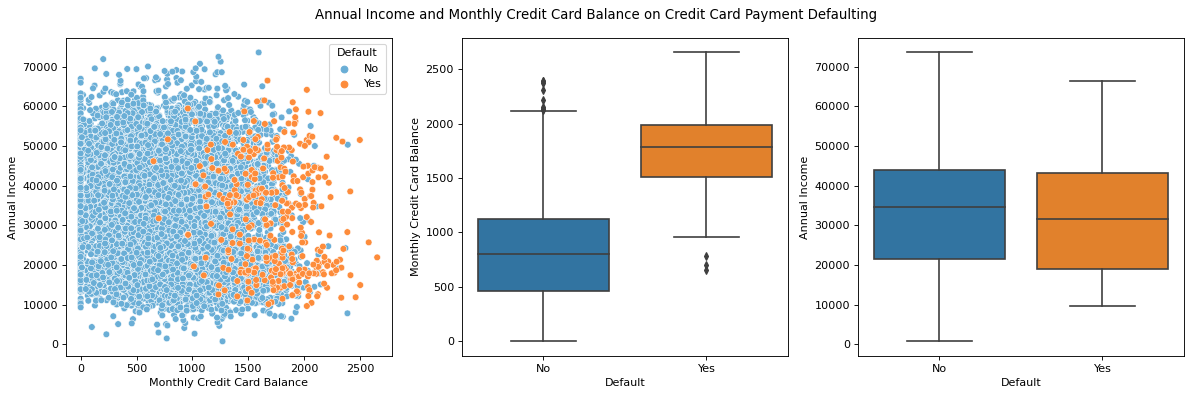

In [8]:
# How variables are related to each other 

balance_label = "Monthly Credit Card Balance"
income_label = "Annual Income"
default_label = "Default"

fig, axes = plt.subplots(ncols = 3, figsize=(15,5))

# Main scatterplots and boxplots for each feature in terms of response 
sns.scatterplot(data = df_default[df_default['default']=="No"], x = "balance", y="income", hue="default", palette='Blues',ax=axes[0])
sns.scatterplot(data = df_default[df_default['default']=="Yes"], x = "balance", y="income",hue="default", palette='Oranges',ax=axes[0])
sns.boxplot(data = df_default, x = "default", y="balance", ax=axes[1])
sns.boxplot(data = df_default, x = "default", y="income", ax=axes[2])

axes[0].legend(title=default_label)
axes[0].set_xlabel(balance_label)
axes[0].set_ylabel(income_label)
axes[1].set_xlabel(default_label)
axes[1].set_ylabel(balance_label)
axes[2].set_xlabel(default_label)
axes[2].set_ylabel(income_label)

plt.suptitle("Annual Income and Monthly Credit Card Balance on Credit Card Payment Defaulting")
plt.tight_layout()
plt.show()

---

### 🚩 Exercise 2 (CORE)

1. Lets now create our feature matrix and response varible.
2.  Split the data into training and test sets (**Is there anything you should try account for when splitting the data ?**) Use the test size as $10\%$ of the whole sample
3. Convert your response variable into the numerical format

>- For data splitting consider the the additional argument inside of `train_test_split` function, stratify in terms of the response data set. Otherwise, without stratify argument. 
>- You can recall the details from here 
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html



In [9]:
# Feature matrix and response separation 
data_x, data_y = df_default.drop(['default'], axis=1), df_default['default']

print(data_x.shape)
print(data_y.shape)

# Before Splitting the data set 
print("Class Distribution (%)")
# get our null accuracy rate 
data_y.value_counts(normalize=True)*100

(10000, 2)
(10000,)
Class Distribution (%)


No     96.67
Yes     3.33
Name: default, dtype: float64

---

As can be seen above, we have an imbalance data problem in our responce varible which we should try keep proportional in our test set. For this reason, you need to use the additional argument inside of `train_test_split` function, stratify in terms of the response data set. Otherwise, without stratify argument, the class proportions in train and testing will be different and it might be problem for building the model on imbalanced data set, like default

Afterwars, we will be careful about that while we are measuring the performance of the model later !

In [10]:
from sklearn.model_selection import train_test_split

features = list(data_x.columns)
X_train, X_test, y_train, y_test = train_test_split(data_x.values, data_y.values, stratify = data_y, 
                                                    test_size = 0.1, random_state=42)


# TO CHECK: The same proportion is satisfied for both train and test data sets 
print(pd.Series(y_train).value_counts(normalize=True)*100)
print(pd.Series(y_test).value_counts(normalize=True)*100)

No     96.666667
Yes     3.333333
dtype: float64
No     96.7
Yes     3.3
dtype: float64


In [14]:
#Converting the response variable 
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)

#Some of the observations that we have, type is numpy array so be careful about the use of head !
y_train[:10], y_test[:10]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0]))

# 2. Logistic Regression <a id='RBH'></a>

As we recall from our notes, for a binary output $y \in \lbrace 0, 1 \rbrace$, **logistic regression** is a classifier that can be seen a simple generalization of linear regression by making two changes. 

- First, we replaced the **Gaussian** distribution of the output $y$ with a **Bernoulli** distribution. 
- Second, we pass the linear function of the inputs, $\mathbf{w}^T\mathbf{x}$, through a **link function** $g: \mathbb{R} \rightarrow [0,1]$. That is, we assume $y \sim Bern( g(\mathbf{w}^T\mathbf{x}))$

The link function takes values in the unit interval to ensure that the conditional probability of a success, 

$$p(y =1 \mid \mathbf{x}) = E[y | \mathbf{x}] = g(\mathbf{w}^T\mathbf{x})$$

is between zero and one. Specifically, in logistic regression, we select the **logistic** link function (sigmoid as an S-shaped), defined as 

$$g(\mathbf{w}^T\mathbf{x}) = \frac{1}{1 + \exp(-\mathbf{w}^T\mathbf{x})}$$

Putting these two steps together, the logistic regression model is:

$$y \sim Bern\left( \left[1 + \exp(-\mathbf{w}^T\mathbf{x})\right]^{-1} \right)$$

To apply this idea with the help of sklearn, the main function that we need to use is `LogisticRegression`. 

- There are important details regarding the implementation of it but the most important note to keep in mind is that the regularization is applied by default with the first input argument `penalty='l2'`
- For further reading, please refer to this website, https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

### 🚩 Exercise 3 (CORE)

- Fit a binary logistic regression model to the training data by using both balance and income as features, **without any regularization**. 
- State the the accuracy score of the model over the testing data

<details><summary><b><u>Hint</b></u></summary>
    
You can consider the `score` function directly
    
</details>


In [15]:
from sklearn.linear_model import LogisticRegression
logfit = LogisticRegression(random_state=42, penalty="none").fit(X_train, y_train)

print(logfit.score(X_test,y_test))

0.974


This result is a bit expected because of the imbalance data problem. If we just look at the accuracy, we can miss the FP ratios so that the accuracy checking is not enough. We will have a look at the confusion matrix details.

## 2.1 Model Predictions

The fitted `LogisticRegression` objects provide multiple prediction methods. Specifically: 

- `predict` which predicts the class label (either 0 or 1), 
- `predict_proba` which predicts the class probabilities, and 
- `predict_log_proba` which predicts the log probabilities of each class


---

### 🚩 Exercise 4 (CORE)

Based on the above fitted logistic regression model, calculate

1. the predictions of the class probabilities
2. Calculate the mean squared error, accuracy score, AUC score of your logistic regression model's predictions. The function `mean_squared_error` , `accuracy_score` and `roc_auc_score` from `sklearn.metrics` will be useful for this. 

See the function documentation if you need [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [16]:
# For class probabilities
print(logfit.predict_proba(X_test))

[[9.98782554e-01 1.21744641e-03]
 [9.99788693e-01 2.11307383e-04]
 [9.38444407e-01 6.15555925e-02]
 ...
 [9.84910073e-01 1.50899269e-02]
 [9.99659584e-01 3.40416290e-04]
 [9.96903740e-01 3.09625950e-03]]


Based on the calculated class probability predictions, our model always predicted the response as 0 (generally, larger values in the first column and very small probabilities in the second column)

In [17]:
# Necessary packages
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

#In terms of testing data 
print("MSE of the fitted model:", mean_squared_error(y_test, logfit.predict(X_test)))
print("Accuracy of the fitted model:", accuracy_score(y_test, logfit.predict(X_test)))
print("AUC of the fitted model:", roc_auc_score(y_test, logfit.predict(X_test)))

MSE of the fitted model: 0.026
Accuracy of the fitted model: 0.974
AUC of the fitted model: 0.679232866409702


If we just look at the accuracy of the model we will interpreted the result incorrect because of the imbalanced data set problem. While MSE is low and AUC seems reasonable rather than the model at a chance, we need to check the quantities in confusion matrix for fair assessment. Besides, the above model used only one training data set, so we need cross-validation idea to see the differences when we change the training / testing data set partitioning 

---

### 🚩 Exercise 5 (CORE)

Consider the given pipeline for the logistic regression model simply. 

- Run 5-fold Cross Validation for this calculation and use the helper function `tidy_scores()` created above for average score calculation.

In [24]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # combining classifier steps

# One can add more model in the dictionary
model_dict = {"log": LogisticRegression(random_state = 42, penalty = "none")}

#print(model_dict[model_name]) 

for model_name in model_dict:
    logistic_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model_dict[model_name])])


scores = tidy_scores(cross_validate(logistic_pipe, X_train, y_train, cv = 5, return_train_score = True))

# For all CV results
print(scores)

print(scores.loc[['mean', 'sd']])

      fit_time  score_time  val_score  train_score
fold                                              
0         0.01         0.0       0.97         0.97
1         0.01         0.0       0.97         0.97
2         0.01         0.0       0.97         0.97
3         0.07         0.0       0.97         0.97
4         0.02         0.0       0.98         0.97
mean      0.02         0.0       0.97         0.97
sd        0.02         0.0       0.00         0.00
      fit_time  score_time  val_score  train_score
fold                                              
mean      0.02         0.0       0.97         0.97
sd        0.02         0.0       0.00         0.00


## 2.2 Performance Metrics

A binary classifier can make two types of errors:

- Incorrectly assign an individual __who defaults__ to the __no default__ category. (FN)
- Incorrectly assign an individual who __does not default__ to the __default__ category. (FP)

where Defaulted (coded as 1) and not defaulted (coded as 0). As we can recall from our notes once again, the main quantities are; 


$$\text{TP} = \sum_{n=1}^N \mathbb{I}(y_n=1)\mathbb{I}(\widehat{y}_n=1),\quad \text{FP} = \sum_{n=1}^N \mathbb{I}(y_n=0)\mathbb{I}(\widehat{y}_n=1)$$
$$\text{FN} = \sum_{n=1}^N \mathbb{I}(y_n=1)\mathbb{I}(\widehat{y}_n=0), \quad \text{TN} = \sum_{n=1}^N \mathbb{I}(y_n=0)\mathbb{I}(\widehat{y}_n=0)$$


where $y_n$ is the true class and $\widehat{y}_n$ is the estimated class. While the overall error rate is low, the error rate among individuals who defaulted is very high. 

- From the perspective of a credit card company that is trying to identify high-risk individuals, this error rate among individuals who default may well be unacceptable.
- From a different persopective, the **lower FN** values are more important compared to the **lower FP** values in this case

---

### 🚩 Exercise 6 (CORE)

- Derive the confusion matrix for the logistic regression model with two predictors by following the above pipeline. Afterwards, derive the followings;

1. False Positive Rate (FPR)
2. True Positive Rate (Recall)
3. Precision
4. F1-score

without using any additional built-in function from any module (You need to recall the definitions from our notes) 

$$
\text{Accuracy} = \frac{\text{TP + TN}}{\text{TP + TN + FP + FN}}
$$

$$
\text{FPR} = \frac{\text{FP}}{\text{FP}+ \text{TN}}, \hspace{0.5cm} \text{Recall (TPR)} = \frac{\text{TP}}{\text{TP}+ \text{FN}} \hspace{0.5cm}
\text{Precision} = \frac{\text{TP}}{\text{TP}+ \text{FP}}
$$


$$
\text{F1-Score} = 2\left(\frac{Precision \times Recall}{Precision + Recall}\right) = \frac{\text{2TP}}{\text{2TP + FP + FN}}
$$

- What can you say about the model performance in terms of Confusion Matrix and obtained quantities 

In [25]:
from sklearn.metrics import confusion_matrix

log_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(random_state=42, penalty = "none"))])

log_pipe.fit(X_train, y_train)

# use the classifier to predict the validation set    
# predictions = log_pipe.predict(X_val)
predictions = log_pipe.predict(X_test)

# get the confusion matrix as a numpy array
#confmat = confusion_matrix(y_true=y_val, y_pred=predictions)
confmat = confusion_matrix(y_true = y_test, y_pred=predictions)

# Just a direct output for the confusion matrix  
confmat

array([[962,   5],
       [ 21,  12]])

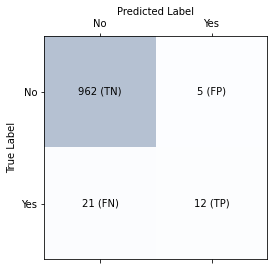

In [26]:
# use the pretty function to make it nicer, you can give some name for LE.classes_ inside of the function
pretty_confusion_matrix(confmat, LE.classes_, "",  labeling = True)

- Basically, all four main quantities can be observed above, with a larger FN (21) value compared to the FP (5). Officially, the model seems reasonable for detecting the people who does not default as non-default (962) whereas this is not as important as having larger TP value because of the nature of problem. Somehow, we need to find a way to reduce our FN value (that stands for defaulted person who is incorrectly assigned as non-default) 


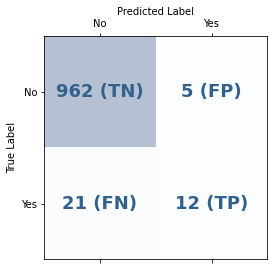

False Positive Rate (FPR): 0.005
Recall: 0.364
Precision: 0.706
F1 Score: 0.480


In [27]:
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)


pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

Here, the confusion matrix content implies an important issue about the values of FN. Basically, FN > TP in that output, as a result Recall value is really small for that logistic fit trial. Because of the that F1 score is also around 0.5. Since we have the imbalanced data set, somehow we need to improve our model in a way that more reasonable Recall value should be derived at the end (Increasing TP and decreasing FN values, of course it can effect TN, FP values based on the our search)

**F1-score**

- As we have seen above, F1-score is a combination of Recall and Precision. 
- It is typically used when there is an __uneven class distribution__ due to a large number of True Negatives that you are not as focused on. 

__Notes__

- Using `sklearn.metrics` this can be gained using `f1_score(y_true=y_test, y_pred=predictions)`

---

### 🚩 Exercise 7 (CORE)

1. Calculate the $F1$ score using `f1_score` function for the logistic regression model with two predictors and compare your result with your calculation obtained before !
2. Draw ROC curve for the same model. Explain the obtained graphical result.  

In [28]:
# By using the available function
from sklearn.metrics import f1_score

f1_score(y_true=y_test, y_pred=predictions)

0.48000000000000004

- We obtained the same F1 score value above when it is compared with our calculations


In [29]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, precision_recall_curve

roc_calc = roc_curve(y_true = y_test, y_score = predictions)
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)

# Values for ROC based on different threshold 
print(roc)

#Print the related AUC value 
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions))

   false positive rate  true positive rate  threshold
0             0.000000            0.000000        2.0
1             0.005171            0.363636        1.0
2             1.000000            1.000000        0.0
AUC value: 0.679232866409702


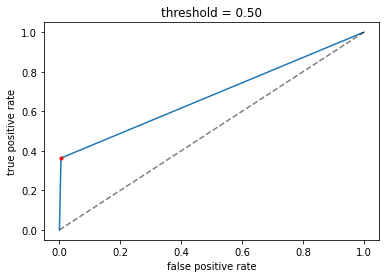

In [30]:
#ROC curve drawing by using the helper function roc_plot above
roc_plot(threshold = 0.5)

>- Using this data frame, the function below creates the ROC curve (blue) via a seaborn lineplot, while the remaining code draws the point on the ROC curve that corresponds to the given threshold value (red), and finally the 0-1 line (grey, dashed)
>- As we decrease the threshold, the red dot moves up and to the right - this makes sense as increasing this threshold will increase both the TPR and the FPR.

__Notes__

- For further reading on different performance metrics see David M. W. Powers' technical report [Evaluation: From Precision,  Recall and F-Factor to ROC, Informedness, Markedness & Correlation](https://arxiv.org/ftp/arxiv/papers/2010/2010.16061.pdf)

## 2.3 Model Refinement <a id='refine'></a>

For those coming from other programming / modeling languages this may be somewhat surprising, this strange default is probably the most common reason that results from sklearn might not immediately match results from other tools. 

- This behavior can be explicitly controlled via the penalty argument, namely C. 
- Note that if you did wish to include a penalty on the coefficients then just like with ridge or lasso it is necessary to tune this penalty parameter. 
- However, `LogisticRegression` does not use alpha for this tuning parameter but instead uses $C$ which is the inverse of the alpha we have been using - i.e. smaller values of $C$ imply more regularization.

For our logistic regression model, lets start by looking at the effects of changing the regularization strength ($C$). Notice that the default value is $C = 1.0$ in `LogisticRegression` function.


---

### 🚩 Exercise 8 (CORE)

1. By completing the following code snippet, derive the related graph. Based on the graphical output, discuss the effects of changing the regularization strength( $C$ ) shortly. 

Note: You can look at the details of `plot_decision_regions` function but not obligatory to run the code !
http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/

In [31]:
# First, install the mlxtend if necessary
!pip install mlxtend

  Using cached mlxtend-0.21.0-py2.py3-none-any.whl (1.3 MB)


Text(0.5, 0.98, 'Logistic Regression Decision Boundaries (Defaulted Validation Data Circled)')

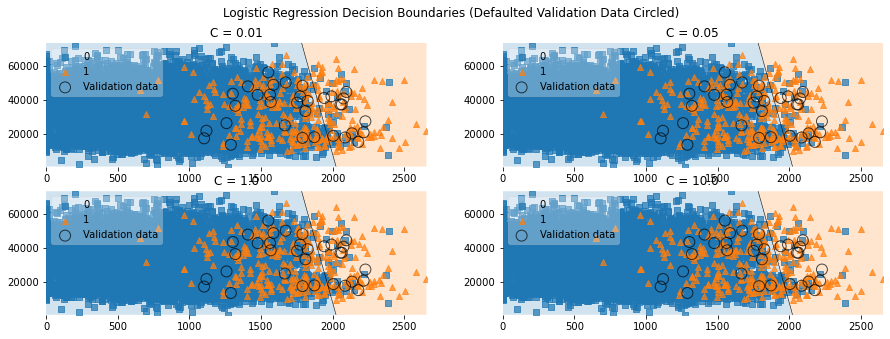

In [32]:
from mlxtend.plotting import plot_decision_regions

scatter_kwargs = {'edgecolor': None, 'alpha': 0.7}
contourf_kwargs = {'alpha': 0.2}
scatter_highlight_kwargs = {'s': 120, 'label': 'Validation data', 'alpha': 0.7}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    fig, axes = plt.subplots(figsize=(15,5), ncols=2, nrows = 2)
    axes = axes.flatten()
    
    for i, c in enumerate([0.01, 0.05, 1., 10.]):
        
        log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = c, random_state=42, penalty = "none"))])

        log_pipe.fit(X_train, y_train)
    
        plot_decision_regions(X_train, y_train, clf = log_pipe, 
                              legend = 2, X_highlight = X_test[y_test==1],
                              contourf_kwargs = contourf_kwargs,
                              scatter_kwargs = scatter_kwargs,
                              scatter_highlight_kwargs = scatter_highlight_kwargs,
                              ax = axes[i]
                             )
        
        axes[i].set_title("C = {}".format(c))
        
plt.suptitle("Logistic Regression Decision Boundaries (Defaulted Validation Data Circled)")

Note that the effect of $C$ on the decision boundary for the logistic regression model is easy to visualize above. When we have smaller $C$ values (it means more regularization because of the fact that $C = \frac{1}{\lambda}$ and larger $\lambda$ results in smaller $C$), the boundary of the classifier is getting nearer to the right-hand side. With this movement, the model can distinguish the class label 1 in a more clear way when we change $C$ from 10.0 to 1.0 (The number of blue squares for class 0 is getting smaller in the light-orange region). However, this linear classifier boundary has certain limitations still since there are lots of class label 1's in the blue region, classified as class 0 and vice verse. 

## 2.4. Grid Search

- Before we start searching over hyperparameters, its worth noting that some of the folds may not have the same distribution of the classes. 
- This means we could get a validation score that may be a poor estimate of performance (for example we may have a fold with very few positive classes or more than usual). 
- Therefore when doing our gridsearch/randomsearch, we should use a `StratifiedKFold` to ensure the distribution of classes in our folds reflects the distribution in the larger data.

You can check the details for `RandomizedSearchCV` function from here 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [33]:
# Example for n_splits = 5 below
# This is about just observing why StratifiedKFold is more suitable and we will use that function below 
# in the RandomizedSearchCV() function
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold

KF = KFold(n_splits = 5)
SKF = StratifiedKFold(n_splits = 5)

fold_names = ["KFold", "StratifiedKFold"]
for i, K in enumerate([KF, SKF]):
    for j, (train_i, test_i) in enumerate(K.split(X_train, y_train)):
        fold_no = pd.DataFrame(pd.Series(y_train[test_i]).value_counts(), columns=["Fold "+str(j)])
        if j == 0:
            fold_nos = fold_no
        else:
            fold_nos = pd.concat([fold_nos,fold_no], axis=1)
        
    print(fold_nos)

   Fold 0  Fold 1  Fold 2  Fold 3  Fold 4
0    1734    1735    1749    1745    1737
1      66      65      51      55      63
   Fold 0  Fold 1  Fold 2  Fold 3  Fold 4
0    1740    1740    1740    1740    1740
1      60      60      60      60      60


In [34]:
from scipy.stats.distributions import uniform, loguniform

log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = c, random_state=42))])

C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr+=2
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1])}

log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "accuracy", 
                            random_state = 42,
                            return_train_score = True)

log_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              LogisticRegression(C=10.0,
                                                                 random_state=42))]),
                   n_iter=60,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa428d34f10>},
                   random_state=42, refit='accuracy', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

### 🚩 Exercise 9 (CORE)

1. Convert your `log_rs.cv_results_` into pandas data frame and sort the values in terms "mean_test_accuracy" in descending order by using `sort_values` function !!!

2. Look at the first 6 values in this sorted values and make comments on test accuracy !!!

In [35]:
# About the summary of best 6 models 
# Convert your log_rs.cv_results_ into pandas data frame and sort the values in terms 
log_rs_df = pd.DataFrame(log_rs.cv_results_)

# "mean_test_accuracy" in descending order by using sort_values !!!
# Look at the first 6 values in this sorted values and make comments on test accuracy !!!
#About the summary of best 6 models 
log_rs_df.sort_values("mean_test_accuracy", ascending=False)[["param_model__C", 
                                                           "mean_train_accuracy",
                                                           "std_train_accuracy",
                                                           "mean_test_accuracy", 
                                                           "std_test_accuracy"]].head()

,param_model__C,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy
4,0.271754,0.973472,0.000489,0.973556,0.001089
5,0.271663,0.973472,0.000489,0.973556,0.001089
44,1.129434,0.973639,0.000309,0.973556,0.001343
13,0.593279,0.973611,0.000430,0.973556,0.001296
30,142.113228,0.973583,0.000309,0.973444,0.001466


In [101]:
# Longer format is 
# log_rs_df.sort_values("mean_test_accuracy", ascending=False).head()

- If we look at the accuracy above, still no improvement appeared in terms of mean accuracy for the testing data. In terms of the Randomized search on hyper parameters, nothing changed if we just compare solely accuarcy here. It seems we need more refinement for the imbalance data issue 

## 2.5. Logistic with Regularization <a id='SKV'></a>

- Note that regularized logistic regression is implemented using the ‘liblinear’ library, ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ solvers in scikits-learn. Note that regularization is applied by default as $L_2$.

- So, to compare logistic regression with any regularization, play with the parameters of `LogisticRegression` function.

### 🚩 Exercise 10 (EXTRA)

1. Rebuild your model described above (`log_rs`) with regularization type `L1` norm
2. Derive the summary performance for the obtained model and discuss your findings

In [36]:
from scipy.stats.distributions import uniform, loguniform

log_pipe_l1 = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = c, random_state=42, penalty = 'l1', solver = 'liblinear'))])

C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr+=2
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1])}

log_rs_l1 = RandomizedSearchCV(log_pipe_l1, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits = 5),
                            refit = "accuracy", 
                            random_state = 42,
                            return_train_score = True)

log_rs_l1.fit(X_train, y_train)

#About the summary of best 6 models 
log_rs_df.sort_values("mean_test_accuracy", ascending=False)[["param_model__C", 
                                                           "mean_train_accuracy",
                                                           "std_train_accuracy",
                                                           "mean_test_accuracy", 
                                                           "std_test_accuracy"]].head()

,param_model__C,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy
4,0.271754,0.973472,0.000489,0.973556,0.001089
5,0.271663,0.973472,0.000489,0.973556,0.001089
44,1.129434,0.973639,0.000309,0.973556,0.001343
13,0.593279,0.973611,0.000430,0.973556,0.001296
30,142.113228,0.973583,0.000309,0.973444,0.001466


>- Under a similar setting, the change of penalty from `l2` to `l1` does not have a real impact on the obtained values
>- Make sure that you are using the suitable solver for the `l1` penalty term, otherwise the code snippet above produces an error

##  3. Improving Models with Imbalances <a id='Imbal'></a>

There are a number of methods to address imbalances in a dataset when we refine our models, such as:

1. Considering the suitable performance metric
2. Weighting the classes in the model during training
3. Resampling the data.

Herein, the main focus is the suitable resampling to change the distribution of the classes in our training data.

## 3.1. Changing Metric

__Optimising for Accuracy__ 

During hyperparameter cross-validation, we selected the model with the best __overall accuracy__. 

- This gives us a model with the smallest possible total number of misclassified observations, irrespective of which class the errors come from. 

- ML algorithms typically optimize a reward or cost function computed as a sum over the training examples, the decision rule is likely going to be biased toward the majority class$^1$.

__Notes__

- _"In other words, the algorithm implicitly learns a model that optimizes the predictions based on the most abundant class in the dataset, in order to minimize the cost or  maximize the reward during training."_<sup>1</sup>.

- You can check the details of `classification_report` function from here 

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [37]:
# This is the classification report based on the accuracy metric
from sklearn.metrics import classification_report

# For the model with l2 penalty already implemented above
print(pd.DataFrame(classification_report(y_test, 
                                   log_rs.predict(X_test), 
                                   labels = None, 
                                   target_names = list(LE.classes_), 
                                   sample_weight = None, 
                                   output_dict = True)).round(2))

               No    Yes  accuracy  macro avg  weighted avg
precision    0.98   0.75      0.98       0.86          0.97
recall       1.00   0.36      0.98       0.68          0.98
f1-score     0.99   0.49      0.98       0.74          0.97
support    967.00  33.00      0.98    1000.00       1000.00


- Changing the metric for what is defined as the _"best model"_ can help us prioritise models that make particular errors.

For example, a credit card company might particularly wish to avoid incorrectly classifying an individual who will default, whereas incorrectly classifying an individual who will not default, though still to be avoided, is less problematic. 

- In this case, __recall__ would therefore be a useful metric to use.

Rather than running another cross-validation again, provided that in `scoring` you used a list that contained "recall", we can just use our results data to pick the model with the best "recall" instead of accuracy.

>- Above, in the classification report we have the text summary of the precision, recall, F1 score for each class. Dictionary returned if `output_dict` is True.
>- Besides note that, The reported averages include macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label), and sample average (only for multilabel classification). 
>- Micro average (averaging the total true positives, false negatives and false positives) is only shown for multi-label or multi-class with a subset of classes, because it corresponds to accuracy otherwise and would be the same for all metrics. 

---

### 🚩 Exercise 11 (CORE)

Consider the following function for the new metric, `recall`, and then derive a similar classification report that you observed above

In [38]:
from sklearn.base import clone

# we refit the best accuracy model on all the training data
# so lets do that for the best other metric models, using the recall below
def manual_refit(input_model, X, y, gs, metric, disp_df=[]):
    output_model = clone(input_model)
    
    gs_df = pd.DataFrame(gs.cv_results_).sort_values("mean_test_" + metric, ascending = False)
    
    if disp_df:
        display(gs_df[disp_df].head())
    
    params = gs_df["params"].iloc[0]
    output_model = output_model.set_params(**params)
    output_model = output_model.fit(X, y)
    
    return output_model

rec_model = manual_refit(log_pipe, X_train, y_train, log_rs, "recall")

In [39]:
print(pd.DataFrame(classification_report(y_test, 
                                   rec_model.predict(X_test), 
                                   labels = None, 
                                   target_names = list(LE.classes_), 
                                   sample_weight = None, 
                                   output_dict = True)).round(2))

               No    Yes  accuracy  macro avg  weighted avg
precision    0.98   0.71      0.97       0.84          0.97
recall       0.99   0.36      0.97       0.68          0.97
f1-score     0.99   0.48      0.97       0.73          0.97
support    967.00  33.00      0.97    1000.00       1000.00


## 3.2. Weighting the classes

During model fitting we can assign a larger penalty to wrong predictions on the minority class.

The heuristic used for `class_weight="balanced"` in Scikit-Learn is:

$$
\frac{n}{Nc \times \sum\limits^n_{i=1}I(y_i \in S)}
$$

where $n$ are the number of samples, $Nc$ the number of classes, $I$ is an indicator function, and $S$ contains the class elements. Remember that the default value is `class_weight=None`. 

---

### 🚩 Exercise 12 (EXTRA)

Conduct a `randomsearch` using the following code chunk, this time also looking at both `C` and `class_weight`. Has this improved performance? 

1. When you change your refit with other scoring alternatives rather than using "accuracy", what is the impact of it on the result (test recall)
2. Is there any improvement when `n_splits = 10` ?    

In [40]:
log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = c, random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {
    'model__C':loguniform(C_list[0], C_list[-1]),
    'model__class_weight': [None, "balanced"]
}

bal_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1", "recall", "precision"], 
                            cv = StratifiedKFold(n_splits = 5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

bal_log_rs.fit(X_train, y_train)

# To convert it as a data frame
bal_log_rs_df = pd.DataFrame(bal_log_rs.cv_results_)

#This is sorted for accuarcy, when you change your refit argument above, be careful about that
bal_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__class_weight", 
                                                                  "param_model__C", 
                                                                  "mean_test_accuracy", "mean_test_recall", 
                                                                  "std_test_accuracy"]].head()

,param_model__class_weight,param_model__C,mean_test_accuracy,mean_test_recall,std_test_accuracy
33,balanced,0.048236,0.863667,0.900000,0.010486
28,balanced,0.050337,0.863778,0.900000,0.010496
9,balanced,0.031589,0.863333,0.900000,0.010617
30,balanced,304.531085,0.865000,0.896667,0.011150
1,balanced,0.397409,0.864889,0.896667,0.011108


In this case, it doesn't seem to be doing much in terms of accuracy. We get similar results that we observed above in terms of mean_test_accuracy so that there is no model improvement. However when we change the refit option with other metric, namely recall, there is a certain improvement on that based on mean recall value (such as balanced class, model param $C=0.048236$, we got 0.90 value recall in terms of the grid search above)

In [41]:
log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = c, random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {
    'model__C':loguniform(C_list[0], C_list[-1]),
    'model__class_weight': [None, "balanced"]
}

bal_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits = 10),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

bal_log_rs.fit(X_train, y_train)

bal_log_rs_df = pd.DataFrame(bal_log_rs.cv_results_)
bal_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__class_weight", 
                                                                  "param_model__C", 
                                                                  "mean_test_accuracy", "mean_test_recall", 
                                                                  "std_test_accuracy"]].head()

,param_model__class_weight,param_model__C,mean_test_accuracy,mean_test_recall,std_test_accuracy
33,balanced,0.048236,0.864444,0.9,0.011675
4,balanced,0.069911,0.864889,0.9,0.011571
7,balanced,0.06831,0.864889,0.9,0.011571
28,balanced,0.050337,0.864667,0.9,0.011694
9,balanced,0.031589,0.864111,0.9,0.011255


The number of splits are increased from 5 to 10 in the `StratifiedKFold` but it has no further impact on the mean_test_recall value when the models are refited in terms of recall metric with all the other parameters are kept fixed. On the other hand, this change has a slight impact on the mean_test_accuracy in for some selection of $C$ values. 

---

### 🚩 Exercise 13 (EXTRA)

- Derive the confusion matrix for each model described above, `rec_model` and `bal_log_rs` using the confusion_matrix function. 
- State the similarity and  differences of the obtained confusion matrices 

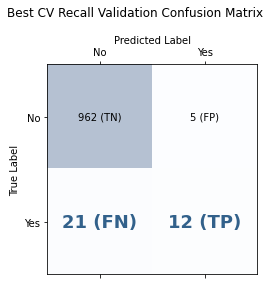

In [42]:
# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = rec_model.predict(X_test))
# use the pretty function to make it nicer
pretty_confusion_matrix(confmat, LE.classes_, 
                        "Best CV Recall Validation Confusion Matrix", labeling = True,
                        highlight_indexes=[FN_i,TP_i]
                       )

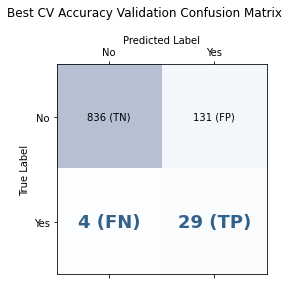

In [43]:
# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = bal_log_rs.predict(X_test))
# use the pretty function to make it nicer
pretty_confusion_matrix(confmat, LE.classes_, 
                        "Best CV Accuracy Validation Confusion Matrix", labeling = True,
                       highlight_indexes=[FN_i,TP_i])

>- With the cost of reducing the TN values and increase on the FP values, we had a certain improvement in terms of the unacceptable FN cases. FN means here the cases in which the person defaulted but the model predicts that the person do not default. 
>- Previosuly, our FN values are much larger than the TP ones but now we got TP = 29, FN = 4 and this results in certain improvement on the Recall value, the metric that we are using for the problem. 
>- As we discussed before, here FN is more expensive than the FP in this setting since classifying a person with default on loan as he/she is not defaulted costs more than predicting a person without default on loan as having a default.  

## 3.3. Resampling

We can change the distribution of the classes in our training data. As we discussed in the notes, there are two main approaches, called as,

- Down-sampling the majority class (Undersampling)
- Up-sampling the minority class (Oversampling)
 

### Under-Sampling

The Down-sampling (Undersampling) involves randomly removing observations from the majority class to prevent its signal from dominating the learning algorithm. 

<div>
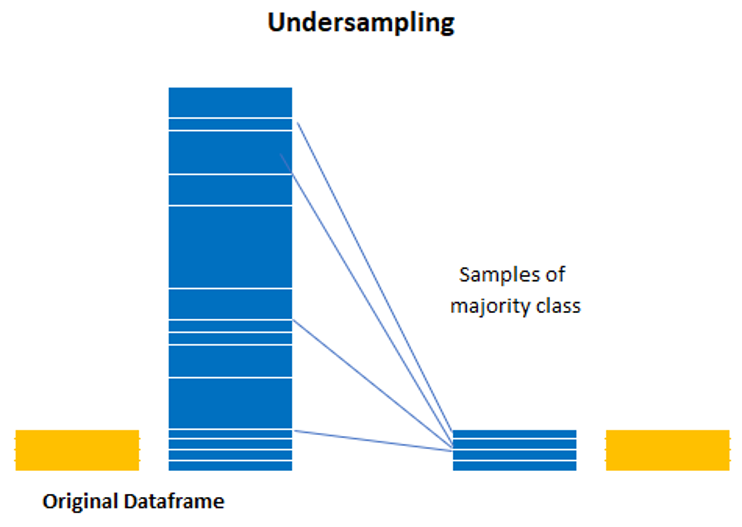
</div>

__Notes__

- `RandomUnderSampler` is part of the Imblearn package, which allows for a lot of techniques for working with imballanced data.
- There is a `resample` method in `scikit-learn` but Imblearn is a bit smoother to work with.
- If you want to use a sampler in a model pipeline then you can use the pipeline from imblearn. Using a sampler in a pipeline ensure you wont be training and validating your data on a smaller/larger sample than normal and get unrepresentative results!

You can check some of the details for `RandomUnderSampler` from here 

https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html

In [44]:
# Install the imblearn if necessary 
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)


In [45]:
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.under_sampling import RandomUnderSampler


log_pipe = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomUnderSampler(random_state=123)),
    ("model", LogisticRegression(random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1])}

us_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1", "recall", "precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

us_log_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('sampler',
                                              RandomUnderSampler(random_state=123)),
                                             ('model',
                                              LogisticRegression(random_state=42))]),
                   n_iter=60,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa428e555e0>},
                   random_state=42, refit='recall', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

In [46]:
us_log_rs_df = pd.DataFrame(us_log_rs.cv_results_)
us_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__C", 
                                                               "mean_test_recall", 
                                                               "std_test_recall"]].head()

,param_model__C,mean_test_recall,std_test_recall
42,0.050337,0.910000,0.059255
10,0.04157,0.910000,0.059255
58,0.058499,0.906667,0.056372
29,0.059499,0.906667,0.056372
56,0.106568,0.906667,0.056372


- Based on the undersampler strategy, there is small improvement on the model based on the Recall value.  

### Oversampling
Data can be oversampled easily by randomly sampling from minority classes with replacement to duplicate original samples.

<div>
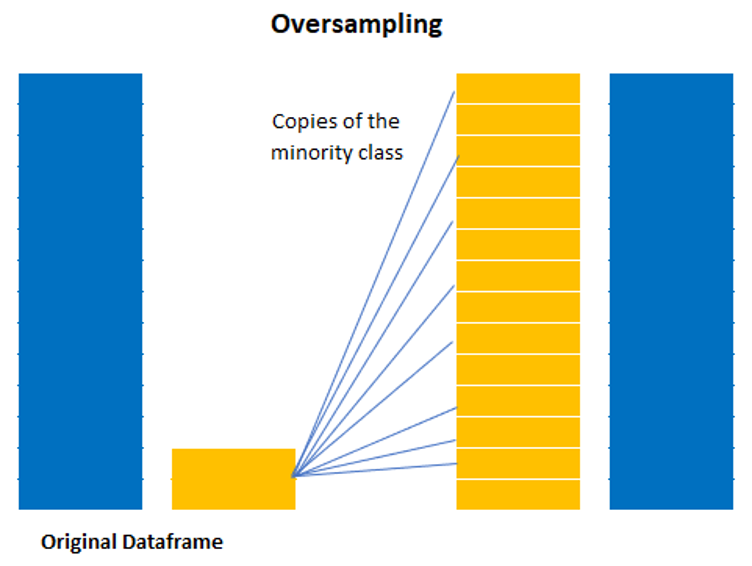
</div>

Note:
- Make sure to oversample after splitting the training and validation sets or you may "bleed" information into the validation sets of the model when trying to test a model
- In-other-words, make sure it is in a pipeline! If you understand the previous mechanism, you can write the `RandomOverSampler` case below !!!

### 🚩 Exercise 14 (CORE)

- Create a similar pipeline for oversampling strategy for the imbalanced data. It is very similar what you observed above as in `log_pipe`

- After getting the results in a similar way, compare the performance in terms of undersampling or oversampling

In [47]:
from imblearn.over_sampling import RandomOverSampler

log_pipe = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomOverSampler(random_state=123)),
    ("model", LogisticRegression(random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1]),}

os_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits = 5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

os_log_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('sampler',
                                              RandomOverSampler(random_state=123)),
                                             ('model',
                                              LogisticRegression(random_state=42))]),
                   n_iter=60,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa428914910>},
                   random_state=42, refit='recall', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

In [48]:
os_log_rs_df = pd.DataFrame(os_log_rs.cv_results_)
os_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__C", 
                                                               "mean_test_recall", 
                                                               "std_test_recall"]].head()

,param_model__C,mean_test_recall,std_test_recall
49,0.405308,0.9,0.05164
14,0.388638,0.9,0.05164
32,0.077002,0.9,0.05164
31,0.332283,0.9,0.05164
29,0.059499,0.9,0.05164


- In terms of the oversampled data, the mean of recall on the testing data is a bit smaller than the result of the undersampling case that we observed above. 
- For this imbalanced data set, the use of undersampling is more beneficial for the improvement of recall value

---
# 4 Multi-class Logistic <a id='mclog'></a>

For this part, basically we will use the `iris` data again, already available to use and it has nice properties in terms of class size over three species. 

- More clearly, this is an example where the response has **3 classes** but we **do not need to worry about the imbalanced issue**

In [49]:
# First load the data here
from sklearn.datasets import load_iris

# Loading data
raw_data = load_iris()
data_desc = raw_data.DESCR
data = pd.DataFrame(raw_data.data, columns=raw_data.feature_names)

# Some information on data set
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [50]:
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Some Visual Inspection on the data set

In [51]:
# Adding the species as a new column
data['species'] = raw_data.target
print(data.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   species  
0        0  
1        0  
2        0  
3        0  
4        0  


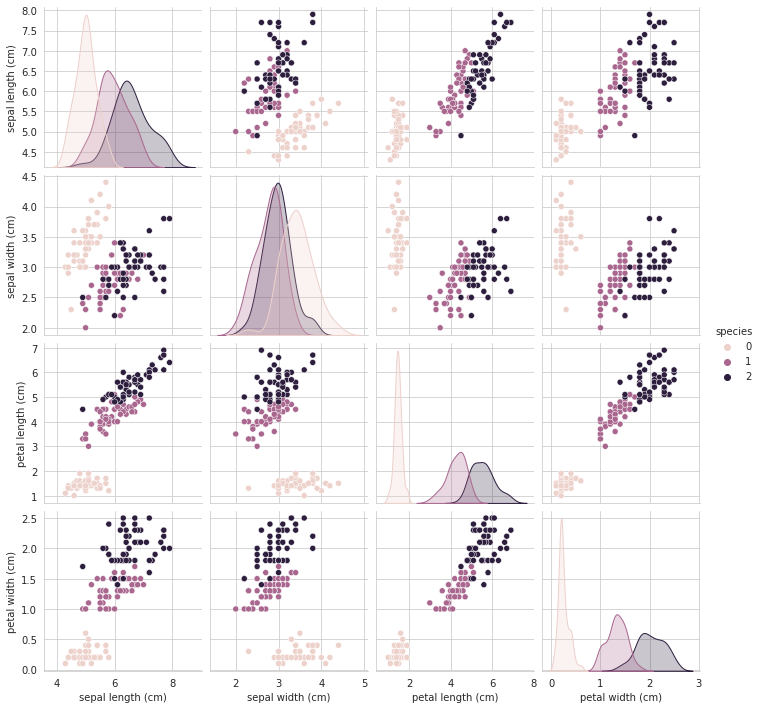

In [52]:
sns.set_style('whitegrid')
sns.pairplot(data, hue='species')
plt.show()


Since we will be attempting to predict the species of flower which is a finite list of categorical options (ie. Setosa, Virginica, Versicolor), we need to assign a numerical value for each of the species within dummy variables. Dummy variables are variables that take binary (True=1, False=0) assignments based on every category in a given column. For example, our categories are Setosa, Virginica and Versicolor. We will have a column for each of these species and will assign a 1 or 0 for each row depending on what species they are. So a sample row representing Setosa, will have the Setosa column value of 1 and the Virginica and Versicolor values would be assigned as 0.

In [53]:
# Consider species_label function as a helper 
# For iris data example 
def species_label(theta):
	if theta==0:
		return raw_data.target_names[0]
	if theta==1:
		return raw_data.target_names[1]
	if theta==2:
		return raw_data.target_names[2]

In [54]:
# data = pd.DataFrame(raw_data.data, columns=raw_data.feature_names)
data['species'] = [species_label(theta) for theta in raw_data.target]
#data['species_id'] = raw_data.target
print(data.head())

# Class size information
print(data.species.value_counts())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  
setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64


In [55]:
#Prepare the data set

#Encoding Species columns (to numerical values)
data['species'] = data['species'].astype('category').cat.codes
print(data['species'])

#Feature & Target Selection
# X = feature values, all the columns except the last column
X = data.iloc[:, :-1]
print(X.head())

# y = target values, last column of the data frame
y = data.iloc[:, -1]
print(y.head())

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: species, Length: 150, dtype: int8
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
0    0
1    0
2    0
3    0
4    0
Name: species, dtype: int8


After partitioning your data set into training and testing with %80-%20 rule,

- Create `One-Vs-Rest Logistic` Regression pipeline and train your model
- Create `Multinomial Logistic` Regression pipeline and train your model

Under this method/strategy a multi-class classification dataset (in our case IRIS) is split into multiple binary classification chunks/datasets. Then a binary classifier (in our case SVC) is trained on each of the binary classification datasets and a prediction(s) is made using the model that has the most confidence value. The IRIS dataset will be split into individual datasets for each Species versus every other Species. Following are the details:

1. Binary Classification: setosa vs versicolor
2. Binary Classification: setosa vs virginica
3. Binary Classification: versicolor vs virginica

Side Not: The **OneVsRestClassifier** class is very easy to use and requires that a classifier that is to be used for binary classification be provided to the **OneVsRestClassifier** as an argument. For this purpose, we need to play around the argument `multi_class`

In [56]:
#SK Learn Libraries
import sklearn
from sklearn.multiclass import OneVsRestClassifier   # 1vsRest Classifiers
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#Split Parameters
test_size = 0.2

#Dataset Split over training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 

#Reset Index
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#Some insight on the selected data set 
X_train.head(), X_test.head(), y_train.head(), y_test.head() 

(    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 22                4.6               3.6                1.0               0.2
 15                5.7               4.4                1.5               0.4
 65                6.7               3.1                4.4               1.4
 11                4.8               3.4                1.6               0.2
 42                4.4               3.2                1.3               0.2,
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0                6.1               2.8                4.7               1.2
 1                5.7               3.8                1.7               0.3
 2                7.7               2.6                6.9               2.3
 3                6.0               2.9                4.5               1.5
 4                6.8               2.8                4.8               1.4,
 22    0
 15    0
 65    1
 11    0
 42    0
 Name: species, dtype: 

### 🚩 Exercise 15 (EXTRA)

- Derive the confusion matrix for each model and compare the quantities to conduct a model comparison
- Test the performance of `One-vs-Rest` and `Multinomial` Logistic models

In [57]:
#Define 1-vs-Rest Strategy / Classifier
# Recall the logistic pipeline as a model
ovr = OneVsRestClassifier(log_pipe)
print(ovr)

#fit model to training data
ovr.fit(X_train, y_train)

#Predictions
ovr_pred = ovr.predict(X_test)
print(ovr_pred)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = ovr_pred)

confmat

OneVsRestClassifier(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('sampler',
                                               RandomOverSampler(random_state=123)),
                                              ('model',
                                               LogisticRegression(random_state=42))]))
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 2 2 1 1 2 0 2 0 2 2 2 2 2 0 0]


array([[10,  0,  0],
       [ 0,  8,  1],
       [ 0,  0, 11]])

<AxesSubplot:>

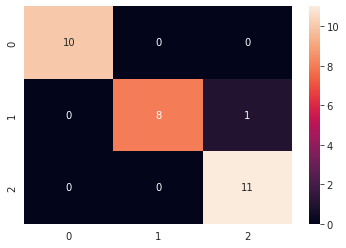

In [58]:
# OR with seaborn as a heat map
import seaborn as sns
sns.heatmap(confmat, annot=True)

In [59]:
# Rather than using the OneVsRestClassifier module one can define the same thing
# with the first pipeline that we observed 

log_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(random_state=42, multi_class = "ovr"))])

log_pipe.fit(X_train, y_train)

# use the first classifier to predict the validation set    
multi_log = log_pipe.predict(X_test)
print(multi_log)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = multi_log)
confmat

[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 2 2 1 1 2 0 2 0 2 2 2 2 2 0 0]


array([[10,  0,  0],
       [ 0,  8,  1],
       [ 0,  0, 11]])

<AxesSubplot:>

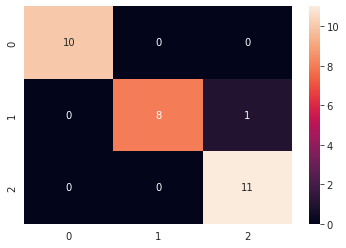

In [60]:
import seaborn as sns
sns.heatmap(confmat, annot=True)

In [61]:
from sklearn.model_selection import cross_validate

model_dict = {
    "log_ovr": LogisticRegression(random_state=42, multi_class = "ovr"),
    "log_multi": LogisticRegression(random_state=42, multi_class = "multinomial")
    }

for model_name in model_dict:
    linear_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model_dict[model_name])])
    
    #Applying Cross-validation with 5-fold
    scores = tidy_scores(cross_validate(linear_pipe, X_train, y_train, cv = 5, return_train_score = True))
    print(scores.loc[['mean', 'sd']])

    predictions = log_pipe.predict(X_test)
    confmat = confusion_matrix(y_true=y_test, y_pred=predictions)
    print(confmat)

    print("F1 score for", f1_score(y_test, predictions, average = "weighted"))

      fit_time  score_time  val_score  train_score
fold                                              
mean      0.01         0.0       0.90         0.94
sd        0.00         0.0       0.09         0.02
[[10  0  0]
 [ 0  8  1]
 [ 0  0 11]]
F1 score for 0.9664109121909632
      fit_time  score_time  val_score  train_score
fold                                              
mean      0.01         0.0       0.96         0.97
sd        0.00         0.0       0.05         0.01
[[10  0  0]
 [ 0  8  1]
 [ 0  0 11]]
F1 score for 0.9664109121909632


---

>- Both approaches are performing quite well and they resulted in equaivalent F1 score results for one-vs-rest and multinomial cases. 
>- The only misclassified observation is that the prediction of class label 1 as a class label 2 above
